In [1]:
import os
import  math
import numpy as np
import tensorflow as tf
from PIL import  Image
import time

#vgg中自带的常量，rgb通道上的三个均值
VGG_MEAN = [103.939,116.779,123.68]

class VGGNet:
    '''builds VGG-16 structure, load parameters from pre-train models'''
    def __init__(self,data_dict):
        self.data_dict = data_dict
        
    '''几个功能函数吧参数从dict中抽取出来'''
    def get_conv_filter(self, name):
        return tf.constant(self.data_dict[name][0], name='conv')
    
    def get_fc_weight(self, name):
        return tf.constant(self.data_dict[name][0], name='fc')
    
    def get_bias(self,name):
        return tf.constant(self.data_dict[name][1], name='bias')
    
    def conv_layer(self, x, name):
        '''Builds convolution layer '''
        with tf.name_scope(name):
            conv_w = self.get_conv_filter(name)
            conv_b = self.get_bias(name)
            #tf.layers.conv2d是一个封装好的api，里面会自动为我们创建w和b，
            #这里已经有了就不创建了,使用一个更基础的api
            h = tf.nn.conv2d(x,conv_w,strides=[1,1,1,1],padding='SAME')
            h = tf.nn.bias_add(h,conv_b)
            h = tf.nn.relu(h)
            return h
    
    def  pooling_layer(self, x, name):
        return tf.nn.max_pool(x,
                                       ksize=[1,2,2,1],
                                       strides=[1,2,2,1],
                                       padding='SAME',
                                       name=name)

    def fc_layer(self, x, name, activation=tf.nn.relu):
        '''Builds fully-connrction layer'''
        with tf.name_scope(name):
            fc_w = self.get_fc_weight(name)
            fc_b = self.get_bias(name)
            h = tf.matmul(x, fc_w)
            h = tf.nn.bias_add(h,fc_b)
            if activation is None:
                return h
            else:
                return activation(h)
        
    def flatten_layer(self, x, name):
        '''Builds flatten-layer'''
        '''[batch_size, image_width, image_hight, channel]'''
        with tf.name_scope(name):
            x_shape = x.get_shape().as_list()
            dim=1
            for d in x_shape[1:4]:
                dim = dim * d
            x = tf.reshape(x,[-1,dim])
            return x
        
        
    def build(self, x_rgb):
        '''Builds VGG16 network structure.
        Parameters:
            - x_rgb: [1,224,224,3]
        '''
        start_time = time.time()
        print('building model........')
        r, g, b = tf.split(x_rgb, 
                              [1,1,1], #三通道被拆成三个1通道要来计算均值
                              axis=3)
        x_bgr = tf.concat([b-VGG_MEAN[0],
                                  g-VGG_MEAN[1],
                                  r-VGG_MEAN[2]],
                                  axis=3)
#         assert x_bgr.get_shape().as_list()[1:] == [224,224,3]
        self.conv1_1 = self.conv_layer(x_bgr, b'conv1_1')#这里名字是不能乱用的，要和vgg16模型中名字一样,因为要在对应位置获取参数
        self.conv1_2 = self.conv_layer(self.conv1_1, b'conv1_2')
        self.pooling1 = self.pooling_layer(self.conv1_2,b'pooling1')
        
        self.conv2_1 = self.conv_layer(self.pooling1,b'conv2_1')
        self.conv2_2 = self.conv_layer(self.conv2_1,b'conv2_2')
        self.pooling2 = self.pooling_layer(self.conv2_2,b'pooling2')
        
        self.conv3_1 = self.conv_layer(self.pooling2,b'conv3_1')
        self.conv3_2 = self.conv_layer(self.conv3_1,b'conv3_2')
        self.conv3_3 = self.conv_layer(self.conv3_2,b'conv3_3')
        self.pooling3 = self.pooling_layer(self.conv3_3,b'pooling3')
        
        self.conv4_1 = self.conv_layer(self.pooling3,b'conv4_1')
        self.conv4_2 = self.conv_layer(self.conv4_1,b'conv4_2')
        self.conv4_3 = self.conv_layer(self.conv4_2,b'conv4_3')
        self.pooling4 = self.pooling_layer(self.conv4_3,b'pooling4')
        
        self.conv5_1 = self.conv_layer(self.pooling4,b'conv5_1')
        self.conv5_2 = self.conv_layer(self.conv5_1,b'conv5_2')
        self.conv5_3 = self.conv_layer(self.conv5_2,b'conv5_3')
        self.pooling5 = self.pooling_layer(self.conv5_3,b'pooling5')
        
        '''图像风格转化用不到全链接层的值，只会用到卷积层的值，可以把全连接层隐掉'''
        '''self.flatten5 = self.flatten_layer(self.pooling5,'flatten')
        self.fc6 = self.fc_layer(self.flatten5,b'fc6')
        self.fc7 = self.fc_layer(self.fc6, b'fc7')
        self.fc8 = self.fc_layer(self.fc7, b'fc8', activation=None)        
        self.prob = tf.nn.softmax(self.fc8,name='prob')
        '''
        
        print('building model finished:%4ds'%(time.time() - start_time))
        

In [2]:
# test_code
vgg16_npy_path = './vgg16.npy'
data_dict = np.load(vgg16_npy_path,encoding='bytes').item()

vgg16_for_result = VGGNet(data_dict)
content = tf.placeholder(tf.float32,shape=[1,224,224,3])
vgg16_for_result.build(content)
#时间都用在创建全连接层的节点上了

building model........
building model finished:   0s


In [3]:
vgg16_npy_path = './vgg16.npy'
conent_img_path = './source_image/gugong.jpg'
style_img_path = './source_image/yinxiang.jpg'

num_step = 100
learning_rate = 10
lambda_c = 0.1
lambda_s = 500

output_dir = './run_style_transfer'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    

In [4]:
def image_resize(filename):
    img = Image.open(filename)
    img = np.array(img,'f')
    img_string = tf.read_file(filename)
    img_decode = tf.image.decode_image(img_string)
    img_decode = tf.reshape(img_decode,[img.shape[0], img.shape[1],img.shape[2]])
    img_val = tf.image.resize_images(img_decode,[224,224])
    return img_val
img1 = image_resize('source_image/gugong.jpg')
print(img1.shape)

(224, 224, 3)


In [5]:
def initial_result(shape, mean, stddev):
    '''要生成的图片，先初始化'''
    initial = tf.truncated_normal(shape,mean=mean, stddev=stddev)#截断的正态分布
    return tf.Variable(initial)

def read_image(image_name):
    img = Image.open(image_name)
    '''jpeg性质不同需要转化成一个array'''
    np_img = np.array(img,'f')#[1080, 1920, 3]
    np_img = np.asarray([np_img], dtype=np.int32)
    return np_img

def gram_matrix(x):
    '''计算gram矩阵 -x：feature extracted from VGG net. shape:[1,width, hight, channel]'''
    b,w,h,ch = x.get_shape().as_list()
    features = tf.reshape(x,[b,h*w,ch]) 
    #真对ch两两计算，得到matrix，选择两列计算相似度-->[ch,ch]-->[i,j]
    #[h*w,ch]matrix-->[ch,h*w]  *  [h*w,ch] -->ch
    #adjoint_a=True是指对第一个参数进行转置
    '''gram矩阵求得的公式'''
    gram = tf.matmul(features,features,adjoint_a=True)/tf.constant(ch*w*h, tf.float32)
    return gram
    
    

result = initial_result((1,224,224,3),127.5,20)
# content_val = read_image(conent_img_path)
# content_val = content_val[:,428:652,428:652,:]
content_val = image_resize(conent_img_path)
# style_val = read_image(style_img_path)
style_val = image_resize(style_img_path)
print(content_val.shape)
# style_val = style_val[:,200:424,400:624,:]
print(style_val.shape)

content = tf.placeholder(tf.float32,shape=[1,224,224,3])
style = tf.placeholder(tf.float32, shape=[1,224,224,3])

'''载入权值'''
data_dict = np.load(vgg16_npy_path,encoding='bytes').item()
vgg_for_content = VGGNet(data_dict)
vgg_for_style = VGGNet(data_dict)
vgg_for_result = VGGNet(data_dict)

'''构建内容图片，风格图片和结果图片的网络架构'''
vgg_for_content.build(content) 
vgg_for_style.build(style)
vgg_for_result.build(result)

content_features = [
    vgg_for_content.conv1_2,
#     vgg_for_content.conv2_2,
#     vgg_for_content.conv3_3,
#     vgg_for_content.conv4_3,
#     vgg_for_content.conv5_3
]

'''定义给三个图像分别抽取那一层的特征'''
result_content_features=[
    vgg_for_result.conv1_2,
#     vgg_for_result.conv2_2,
#     vgg_for_result.conv3_3,
#     vgg_for_result.conv4_3,
#     vgg_for_result.conv5_3
]

'''注意：内容图像和结果图像的内容抽取特征一致，
            风格图像和结果图像的风格抽取特征一致'''
style_features=[
#     vgg_for_style.conv1_2,
#     vgg_for_style.conv2_2,
#     vgg_for_style.conv3_3,
    vgg_for_style.conv4_3,
#     vgg_for_style.conv5_3
]

'''图像的风格特征生成gram矩阵'''
style_gram = [gram_matrix(feature) for feature in style_features]

result_style_features=[
#     vgg_for_result.conv1_2,
#     vgg_for_result.conv2_2,
#     vgg_for_result.conv3_3,
    vgg_for_result.conv4_3,
#     vgg_for_result.conv5_3
]

'''结果图像的风格特征生成gram矩阵'''
result_style_gram = [gram_matrix(feature) for feature in result_style_features]

'''内容损失,因为上面把内容特征写在数组里了'''
content_loss = tf.zeros(1,tf.float32)
#shape-->[1,width, hight, channel]
for c, c_ in zip(content_features, result_content_features):
    content_loss += tf.reduce_mean((c - c_)**2, [1,2,3])#width, hight, channel上分别作平均
    
'''风格损失'''
style_loss  = tf.zeros(1,tf.float32)
for s, s_ in zip(style_gram,result_style_gram):
    style_loss += tf.reduce_mean((s - s_)**2,[1,2])

loss = content_loss*lambda_c + style_loss *lambda_s
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)


(224, 224, 3)
(224, 224, 3)
building model........
building model finished:   0s
building model........
building model finished:   0s
building model........
building model finished:   0s


In [8]:
'''训练流程'''
init_op = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init_op)
    for step in range(num_step):
        #转shape
        content_val = tf.reshape(content_val,[-1,224,224,3])
        style_val = tf.reshape(style_val,[-1,224,224,3])
        #tensor转numpy
        content_val = content_val.eval(session=sess)
        style_val = style_val.eval(session=sess)
        loss_val, content_loss_val, style_loss_val, _ \
        =sess.run([loss, content_loss,style_loss,train_op],
                    feed_dict = {
                        content: content_val,
                        style:style_val
                    })

        print('step: %d, loss_val:%8.4f,  content_loss: %8.4f,  style_loss:%8.4f'%(step+1, 
                                                                                                                loss_val[0], #因为创建的时候shape为1
                                                                                                                content_loss_val[0],
                                                                                                                style_loss_val[0]))
        
        result_img_path = os.path.join(output_dir,'result-%05d.jpg'%(step+1))
        result_val = result.eval(sess)[0]#可以讲结果图像变量的值取出来见26行

        res_val = np.clip(result_val, 0, 255)#对值进行裁剪小雨0的设成0，大于255的设成255
        img_arr = np.asanyarray(result_val,np.uint8)#图片设置成unit8完成就能用PIL裁剪，操作
        if step%10 == 0:
            img = Image.fromarray(img_arr)
            img.save(result_img_path)

<class 'numpy.ndarray'>
step: 1, loss_val:20625.8359,  content_loss: 41398.0156,  style_loss: 32.9721
<class 'numpy.ndarray'>
step: 2, loss_val:17909.5957,  content_loss: 31734.2344,  style_loss: 29.4723
<class 'numpy.ndarray'>
step: 3, loss_val:13726.8174,  content_loss: 28873.4395,  style_loss: 21.6789
<class 'numpy.ndarray'>
step: 4, loss_val:10770.7354,  content_loss: 28463.9492,  style_loss: 15.8487
<class 'numpy.ndarray'>
step: 5, loss_val:9511.8867,  content_loss: 29257.2695,  style_loss: 13.1723
<class 'numpy.ndarray'>
step: 6, loss_val:8978.8896,  content_loss: 30298.0898,  style_loss: 11.8982
<class 'numpy.ndarray'>
step: 7, loss_val:7639.0156,  content_loss: 31822.1602,  style_loss:  8.9136
<class 'numpy.ndarray'>
step: 8, loss_val:7559.9492,  content_loss: 33546.4453,  style_loss:  8.4106
<class 'numpy.ndarray'>
step: 9, loss_val:6981.8916,  content_loss: 35003.8359,  style_loss:  6.9630
<class 'numpy.ndarray'>
step: 10, loss_val:6793.9072,  content_loss: 36385.5781,  style

<class 'numpy.ndarray'>
step: 82, loss_val:1917.1709,  content_loss: 11522.9004,  style_loss:  1.5298
<class 'numpy.ndarray'>
step: 83, loss_val:1834.0406,  content_loss: 11518.7217,  style_loss:  1.3643
<class 'numpy.ndarray'>
step: 84, loss_val:1860.5288,  content_loss: 11448.7236,  style_loss:  1.4313
<class 'numpy.ndarray'>
step: 85, loss_val:1805.1118,  content_loss: 11390.1846,  style_loss:  1.3322
<class 'numpy.ndarray'>
step: 86, loss_val:1802.5203,  content_loss: 11313.2549,  style_loss:  1.3424
<class 'numpy.ndarray'>
step: 87, loss_val:1775.8226,  content_loss: 11201.8223,  style_loss:  1.3113
<class 'numpy.ndarray'>
step: 88, loss_val:1750.5864,  content_loss: 11096.0508,  style_loss:  1.2820
<class 'numpy.ndarray'>
step: 89, loss_val:1750.3887,  content_loss: 10974.7109,  style_loss:  1.3058
<class 'numpy.ndarray'>
step: 90, loss_val:1711.3875,  content_loss: 10867.2324,  style_loss:  1.2493
<class 'numpy.ndarray'>
step: 91, loss_val:1709.6084,  content_loss: 10712.9111,  

In [9]:
vgg16_npy_path = './vgg16.npy'
conent_img_path = './source_image/gugong.jpg'
style_img_path = './source_image/yinxiang.jpg'
content_val = read_image(conent_img_path)
content_val = content_val[428:652,428:652,:]
style_val = read_image(style_img_path)
print(style_val.shape)
style_val = style_val[200:424,400:624,:]
print(style_val.shape)

(1, 644, 1024, 3)
(0, 224, 1024, 3)


In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

(1080, 1920, 3)


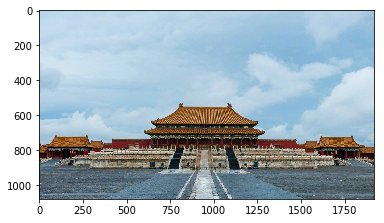

In [11]:
name = './source_image/gugong.jpg'
img_string = tf.read_file(name)
img_decode = tf.image.decode_image(img_string)
sess = tf.Session()
img_decode_val = sess.run(img_decode)
print(img_decode_val.shape)
%matplotlib inline
imshow(img_decode_val)